In [1]:
import numpy as np
import matplotlib.pyplot as plt
from lassoData import *
import pdb
import math
import copy
from sklearn.linear_model import Ridge, Lasso, SGDRegressor, LinearRegression

In [2]:
x_train, Y_train = lassoTrainData()
x_test, Y_test = lassoTestData()
x_val, Y_val = lassoValData()

In [3]:
def Phi(x):
    ret = ([x[0]]+[math.sin(0.4*x[0]*i*math.pi) for i in range(1,13)])
    #ret.reverse()
    return ret
def PhiMap(X):
    return np.array([Phi(x) for x in X])

In [4]:
X_train = PhiMap(x_train)
X_test = PhiMap(x_test)
X_val = PhiMap(x_val)

In [5]:
len(Phi(X_train[0]))

13

In [6]:
class SGD(object):
    
    def __init__(self, X, y, L,
                 step_size=1e-5):
        self.X = X
        self.y = y
        self.L = L
        self.step_size = step_size
    
    def compute_objective(self, theta, X=None, y=None):
        if X == None:
            X = self.X
            y = self.y
        sum_of_squares = sum([(X[i].dot(theta)-y[i])**2 for i in range(len(y))])/len(y)
        return sum_of_squares + self.L*sum([abs(coord)**1 for coord in theta])
    
    def compute_numerical_gradient(self, theta, eps=1e-7):
        grad = np.zeros(len(theta))
        for i in range(len(theta)):
            f = self.compute_objective(theta)
            theta[i] = theta[i] + eps
            f_eps = self.compute_objective(theta)
            theta[i] = theta[i] - eps
            grad[i] = (f_eps-f)/eps
        return grad
        
    def compute_gradient(self, theta, idx=None):
        if idx == None:
            idx = range(len(self.y))
        grad = np.zeros(self.X.shape[1])
        for i in idx:
            grad += 2 * (self.X[i].dot(theta) - self.y[i]) * self.X[i]
        return grad
    
    def line_search(self, theta, search_dir, step_size=1e-6):
        best_val = self.compute_objective(theta-step_size*search_dir)
        while True:
            new_val = self.compute_objective(theta-2.0*step_size*search_dir)
            if new_val < best_val:
                step_size *= 2.0
                best_val = new_val
            else:
                break
        while step_size > 1e-8:
            new_val = self.compute_objective(theta-0.5*step_size*search_dir)
            if new_val < best_val:
                step_size *= 0.5
                best_val = new_val
            else:
                break
        return step_size
    
    def step(self, theta, numerical=True, stochastic=False, minibatch_size=1, ftol=1e-9, gtol=1e-2):
        log = []
        idx = None
        prev_objective = self.compute_objective(theta)
        beta = 0.8
        t = 0.0
        while True:
            if stochastic:
                idx = np.random.randint(self.X.shape[0], size=minibatch_size)

            if numerical:
                grad = self.compute_numerical_gradient(theta)
            else:
                grad = self.compute_gradient(theta, idx)
            
            step_size = self.line_search(theta, grad)
            theta = theta - step_size * grad
            
            tmp = self.compute_objective(theta)
            log.append((theta, tmp, grad))
            
            if abs(prev_objective-tmp) < ftol:
                print "function convergence"
                break
            if np.linalg.norm(self.compute_gradient(theta)) < gtol:
                print "gradient convergence"
                break
            
            prev_objective = tmp
            t += 1.0
            print log[-1][1], np.linalg.norm(log[-1][2])
            print "step size", step_size
        return log

In [7]:
optimizer = SGD(X_train,Y_train, 0.01)

In [8]:
theta_0 = np.random.random(X_train.shape[1])

In [9]:
log = optimizer.step(copy.copy(theta_0), numerical=True);

[ 0.9127267] 8.08132205553
step size 0.262144
[ 0.25015735] 1.69653661486
step size 0.524288
[ 0.17178425] 0.684993654186
step size 0.262144
[ 0.13597204] 0.275789778448
step size 1.048576
[ 0.12933647] 0.206183049205
step size 0.262144
[ 0.12845208] 0.054247296427
step size 0.524288
[ 0.12801701] 0.0366227068828
step size 0.524288
[ 0.12774727] 0.0279225701818
step size 0.524288
[ 0.12754101] 0.0244868564521
step size 0.524288
[ 0.12736134] 0.0240137538484
step size 0.524288
[ 0.12719603] 0.0252356041158
step size 0.524288
[ 0.1270428] 0.0276704122334
step size 0.524288
[ 0.12688008] 0.0312614694533
step size 0.262144
[ 0.12531953] 0.018616368646
step size 8.388608
[ 0.12399314] 0.10489216082
step size 0.262144
[ 0.12381862] 0.022379410477
step size 0.524288
[ 0.12365323] 0.023817389823
step size 0.524288
[ 0.12349675] 0.0260970601789
step size 0.524288
[ 0.12335353] 0.0293151248622
step size 0.262144
[ 0.12328209] 0.0236295053833
step size 0.524288
[ 0.12308754] 0.0261822941765
step 

In [10]:
log[-1]

(array([  1.95698670e+00,   2.10678269e+00,   1.92788500e+00,
          1.02159225e+00,   1.22474728e+00,   1.02659243e+00,
          1.19445478e+00,   9.15599699e-01,  -2.99371417e-10,
         -2.33955127e-01,  -4.23391252e-08,   2.82012812e-02,
          3.60027881e-03]),
 array([ 0.11658254]),
 array([ 0.00112692,  0.00038023, -0.00230707,  0.00074386,  0.00245117,
        -0.00056912, -0.00358007, -0.00027964,  0.00815254, -0.00654296,
         0.00816908,  0.00230038, -0.0006708 ]))

In [11]:
theta = [0.0, 0.0, 5.6463, 0.7786, 0.0, 0.8109, 2.6827, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
#theta.reverse()
optimizer.compute_objective(theta)

array([ 0.149185])

In [12]:
def plot_fit(original, lasso):
    original = np.array(original)
    lasso = np.array(lasso)
    X = [-1+i*0.02 for i in range(100)]
    Y_orig = [np.array(Phi([x])).dot(original) for x in X]
    Y_lasso = [np.array(Phi([x])).dot(lasso) for x in X]
    plt.plot(X, Y_orig, 'r-')
    plt.plot(X, Y_lasso, 'b--')
    #plt.scatter(x_train.flatten(), Y_train.flatten(), c='b', marker=(_,3,_))
    #plt.scatter(x_test, Y_test, c='g', marker='o')
    #plt.scatter(x_val, Y_val, c='r', marker='o')
    plt.show()

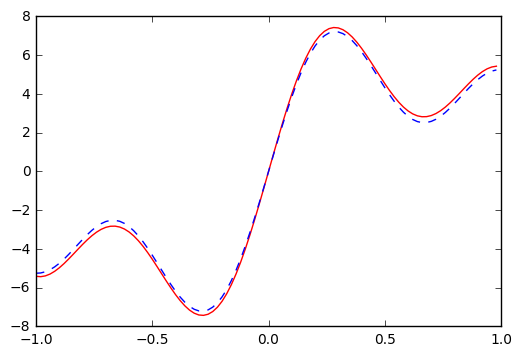

In [13]:
plot_fit(theta, log[-1][0])

Ridge Lambda 0.160603015075
Lasso Lambda 0.0100606060606


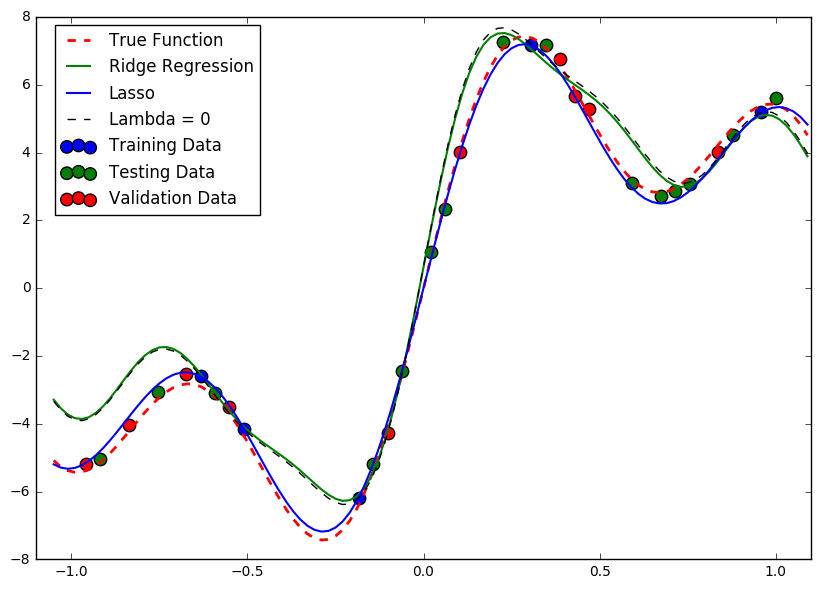

In [16]:
clf_normal = LinearRegression()
clf_normal.fit(X_train, Y_train)

L = np.linspace(0.01,10.0,200)
val_err = []
for l in L:
    clf = Ridge(l)
    clf.fit(X_train, Y_train)
    val_err.append(clf.score(X_val, Y_val))
clf_ridge = Ridge(L[np.argmax(val_err)])
#clf_ridge = Ridge(1.0)
clf_ridge.fit(X_train, Y_train)
print "Ridge Lambda", L[np.argmax(val_err)]

L = np.linspace(0.001,0.3,100)
val_err = []
for l in L:
    clf = Lasso(l)
    clf.fit(X_train, Y_train)
    val_err.append(clf.score(X_val, Y_val))
clf_lasso = Lasso(L[np.argmax(val_err)])
clf_lasso.fit(X_train, Y_train)
print "Lasso Lambda", L[np.argmax(val_err)]

plot_clf(theta, clf_ridge ,clf_lasso, clf_normal)

In [15]:
def plot_clf(original, clf_ridge, clf_lasso, clf):
    s1 = 80
    original = np.array(original)
    X = [-1.05+i*0.02 for i in range(108)]
    Y_orig = [np.array(Phi([x])).dot(original) for x in X]
    Y_ridge = [clf_ridge.predict([Phi([x])])[0][0] for x in X]
    Y_lasso = [clf_lasso.predict([Phi([x])]) for x in X]
    Y = [clf.predict([Phi([x])])[0][0] for x in X]
    plt.figure(figsize=(10,7))
    plt.plot(X, Y_orig, 'r--', label='True Function', linewidth=2.0)
    plt.plot(X, Y_ridge, 'g-', label='Ridge Regression', linewidth=1.5)
    plt.plot(X, Y_lasso, 'b-', label='Lasso', linewidth=1.5)
    plt.plot(X, Y, 'k--', label='Lambda = 0')
    plt.scatter(x_train.flatten(), Y_train.flatten(), label='Training Data', facecolor="b", edgecolor='k', s=s1)
    plt.scatter(x_test.flatten(), Y_test.flatten(), label='Testing Data', facecolor="g", edgecolor='k', s=s1)
    plt.scatter(x_val.flatten(), Y_val.flatten(), label='Validation Data', facecolor="r", edgecolor='k', s=s1)
    plt.legend(bbox_to_anchor=(0.3, 1))
    axes = plt.gca()
    axes.set_xlim([-1.1,1.1])
    axes.set_ylim([-8,8])
    plt.show()

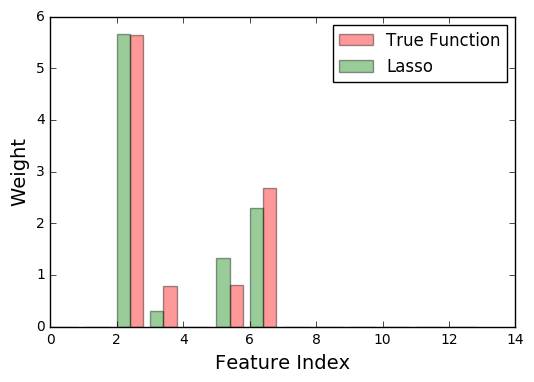

In [109]:
alpha = 0.4
width = 0.4
fig, ax = plt.subplots()
ax.bar(np.array(range(13))+0.4, theta, width, color='r', alpha=alpha, label='True Function')
ax.bar(range(13), clf_lasso.coef_.flatten(), width, color='g', alpha=alpha, label='Lasso')
plt.legend()
plt.xlabel('Feature Index', fontsize=14)
plt.ylabel('Weight', fontsize=14)
plt.show()
plt.close()

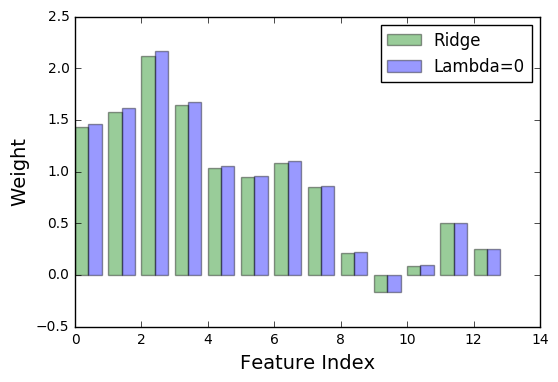

In [107]:
alpha = 0.4
width = 0.4
fig, ax = plt.subplots()
ax.bar(range(13), clf_ridge.coef_.flatten(), width, color='g', alpha=alpha, label='Ridge')
ax.bar(np.array(range(13))+0.4, clf_normal.coef_.flatten(), width, color='b', alpha=alpha, label='Lambda=0')
plt.legend()
plt.xlabel('Feature Index', fontsize=14)
plt.ylabel('Weight', fontsize=14)
plt.show()
plt.close()

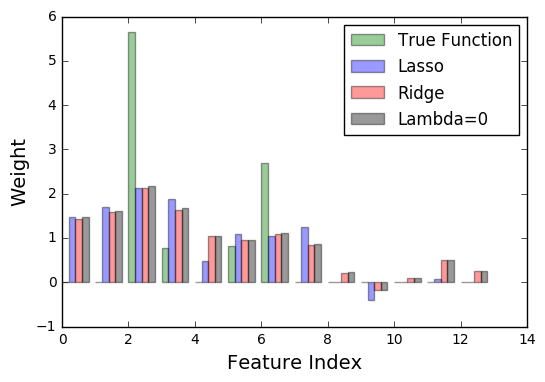

In [108]:
alpha = 0.4
width = 0.2
fig, ax = plt.subplots()
ax.bar(np.array(range(13)), theta, width, color='g', alpha=alpha, label='True Function')
#ax.bar(np.array(range(13))+0.2, clf_lasso.coef_.flatten(), width, color='b', alpha=alpha, label='Lasso')
ax.bar(np.array(range(13))+0.2, log[-1][0], width, color='b', alpha=alpha, label='Lasso')
ax.bar(np.array(range(13))+0.4, clf_ridge.coef_.flatten(), width, color='r', alpha=alpha, label='Ridge')
ax.bar(np.array(range(13))+0.6, clf_normal.coef_.flatten(), width, color='k', alpha=alpha, label='Lambda=0')
plt.legend()
plt.xlabel('Feature Index', fontsize=14)
plt.ylabel('Weight', fontsize=14)
plt.show()
plt.close()